In [232]:
# python libraries
import matplotlib.pyplot as plt
import numpy as np
import csv
import copy 
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Polygon, Wedge

In [80]:
# create list of weekends
weekends = []
for i in range(1,366):
    if (i/7).is_integer():
        weekends.extend(range(i+1,i+3))

# create function for list of simulated demand
def fun_demand():
    # creat empty list 
    sim_demand = []
    
    for i in range(1,366):
        # add random value to each week
        if ((i-1)/7).is_integer():
            week_rand = int(abs(np.random.normal(0, 3e4 , 1)))
        
        # weekdays
        if i not in weekends:
            sim_demand.append(int(6e5 + 1.2e5*np.sin(0.02*(i+35)) + abs(np.random.normal(0, 3e4 , 1))) + week_rand)
    
        # weekends
        else:
            sim_demand.append(int(6e5 + 1.2e5*np.sin(0.02*(i+35)) + np.random.normal(-4e4, 2e4 , 1)))
    
    # return list
    return sim_demand

In [81]:
# determine average demand per day
demand1 = fun_demand()
total1 = 0
for i in range(0,len(demand1)):
    total1 += demand1[i]
print(total1/365)

638681.8246575342


In [82]:
# function to simulate wind production
def fun_wind(k):
    #create list
    sim_wind = []
    
    # set parameters
    a = 6
    b = 1
    c = 0.017
    d = 75

    for i in range(1,366):
        # generate value
        wind = float(k*(a + b*np.sin(c*(i+d)) + np.random.normal(0, 1.75 , 1)[0]))
    
        # set minimum value
        if wind < k*0.2:
            sim_wind.append(k*0.2)
        else:
            # set maximum value
            if wind > k*19:
                sim_wind.append(k*19)
            else:
                sim_wind.append(wind)
    
    # return list
    return sim_wind

In [89]:
# function to simulate storage
def fun_storage(k,days):
    # set initial value (full)
    storage = days/2*8e5
    
    # create empty list
    total_stored = []

    # generate the wind and demand lists once
    temp_wind = fun_wind(k)
    temp_demand = fun_demand()

    # loop each day
    for i in range(0,365):
        # update storage value
        storage += 0.8*(temp_wind[i] - temp_demand[i])
    
        # cap storage value
        if storage > days*6.5e5:
            storage = days*6.5e5
        
        # update total stored list
        total_stored.append(float(storage))
        
    # return total stored list
    return total_stored

In [112]:
# create lists of possible values for k and days
pos_k = np.linspace(9e4,2.1e5,40)
pos_days = np.linspace(0,2,40)

# create empty percentage list
pct_list = []

# run simulations to gather statistics
for i in range(0,len(pos_k)):
    for j in range(0,len(pos_days)):
        # set success rate to 0
        success_rate = 0
        
        for k in range(0,100):
            # check if the run succeeds
            if any(n < 0 for n in fun_storage(pos_k[i],pos_days[j])) is False:
                success_rate += 1
        
        # add success rate to list
        pct_list.append([pos_k[i],pos_days[j],success_rate/100])

In [152]:
# create percentage to colour function
def col(pct):
    pct_diff = 1.0 - pct
    red_color = min(255, pct_diff*2*255)
    green_color = min(255, pct*2*255)
    return (red_color/255, green_color/255, 0)

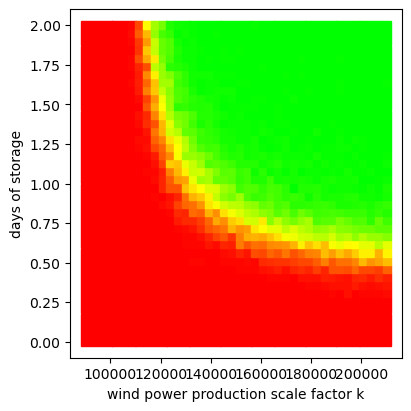

In [153]:
# set up plot
fig, axs = plt.subplots(1,1,layout='constrained',figsize=(4,4))

# creat list of x points
x_pts = np.linspace(1,365,365)

# plot graph
for i in range(0,len(pct_list)):
    axs.plot(pct_list[i][0],pct_list[i][1],'s',color=col(pct_list[i][2]),markersize=5.5)
axs.set_ylabel('days of storage')
axs.set_xlabel('wind power production scale factor k')

plt.show()

In [154]:
# function determining the cost of wind production for different values of k
def wind_cost(k):
    # generate 100 times to find an average
    wind_each_year = []
    for i in range(0,10):
        # set up wind total value
        yearly_wind_total = 0
    
        # generate wind production value array once
        wind_values = fun_wind(k)

        # sum the total wind production over a year
        for i in range(0,365):
            yearly_wind_total += wind_values[i]
        
        # enter values into the wind each year list
        wind_each_year.append(yearly_wind_total)
    
    # determine average wind
    total_wind = 0
    for i in range(0,len(wind_each_year)):
        # sum all values for wind each year
        total_wind += wind_each_year[i]
    
    # determine average
    avg_wind_per_year = total_wind/10

    # return cost in £ based on 41 £/MWh
    return avg_wind_per_year*41

# function for fitted wind cost
def rough_wind_cost(x):
    return 0.895e5*x

In [299]:
# function determining the cost of pumped storage hydro for different days values
def storage_cost(days):
    # return cost in £ based on 9,850 £/MWh/year
    return 9.85e3*days*6.5e5

In [300]:
# assign cost values to pct_list
pct_copy = copy.deepcopy(pct_list)
for i in range(0,len(pct_copy)):
    pct_copy[i].append(rough_wind_cost(pct_list[i][0]))
    pct_copy[i].append(storage_cost(pct_list[i][1]))    

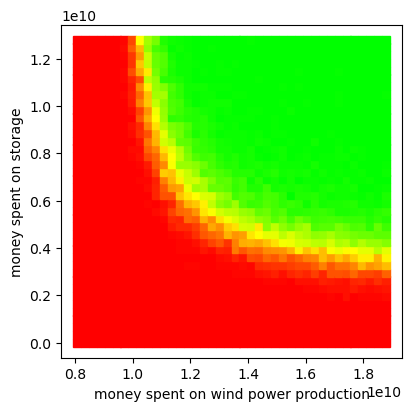

In [301]:
# set up plot
fig, axs = plt.subplots(1,1,layout='constrained',figsize=(4,4))

# plot graph
for i in range(0,len(pct_copy)):
    axs.plot(pct_copy[i][3],pct_copy[i][4],'s',color=col(pct_copy[i][2]),markersize=5.5)
axs.set_ylabel('money spent on storage')
axs.set_xlabel('money spent on wind power production')


plt.show()

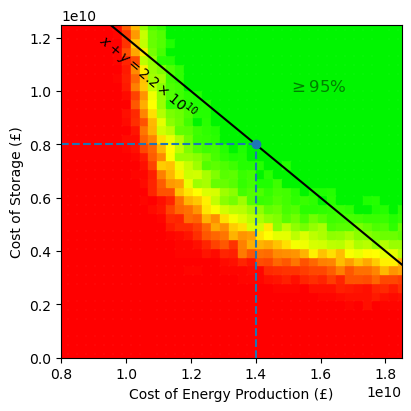

In [334]:
x = np.linspace(0.795e10,1.895e10,50)
y1 = lambda x: 2.2e10 - x 

# set up plot
fig, axs = plt.subplots(1,1,layout='constrained',figsize=(4,4))

# plot graph
for i in range(0,len(pct_copy)):
    if pct_copy[i][2] < 0.95:
        axs.plot(pct_copy[i][3],pct_copy[i][4],'s',color=col(pct_copy[i][2]),markersize=5.55)
    if pct_copy[i][2] >= 0.95:
        axs.plot(pct_copy[i][3],pct_copy[i][4],'s',color=(0, 245/255, 0),markersize=5.55)
axs.plot(x,y1(x), color='black')
#axs.plot(x,y2(x), color='black')
axs.set_ylabel('Cost of Storage (£)')
axs.set_xlabel('Cost of Energy Production (£)')
axs.annotate(r'$x+y=2.2 \times 10^{10}$', (0.9e10, 0.9e10), rotation=-40)
axs.annotate(r'$\geq 95\%$', (1.5e10, 1e10), color='green', fontsize=12)
axs.plot(1.4e10,0.8e10, 'o', color='tab:blue')
axs.hlines(y=0.8e10, xmin=0.8e10, xmax=1.4e10, linestyle='dashed', color='tab:blue')
axs.vlines(x=1.4e10, ymin=0, ymax=0.8e10, linestyle='dashed', color='tab:blue')
axs.set_ylim(top=1.25e10, bottom=0)
axs.set_xlim(left=0.8e10, right=1.85e10)
axs.set_yticks([0.0e10, 0.2e10, 0.4e10, 0.6e10, 0.8e10, 1.0e10, 1.2e10])
axs.set_xticks([0.8e10, 1.0e10, 1.2e10, 1.4e10, 1.6e10, 1.8e10])


plt.savefig('Cost Analysis', dpi=500)